In [ ]:
#Checking camera for working
import cv2

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Camera not accessible")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
#Collecting data for all labels

import os
import cv2

DATA_DIR = './data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

number_of_classes = 26
dataset_size = 150

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Unable to access the camera")
    exit()

for j in range(number_of_classes):
    class_dir = os.path.join(DATA_DIR, str(j))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    print('Collecting data for class {}'.format(j))

    while True:
        ret, frame = cap.read()
        if not ret or frame is None:
            print("Error: Unable to read frame")
            break

        frame = cv2.flip(frame, 1)

        cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                    cv2.LINE_AA)
        cv2.imshow('frame', frame)
        if cv2.waitKey(25) == ord('q'):
            break

    counter = 0
    while counter < dataset_size:
        ret, frame = cap.read()
        if not ret or frame is None:
            print("Error: Unable to read frame")
            break

        frame = cv2.flip(frame, 1)

        cv2.imshow('frame', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        cv2.imwrite(os.path.join(class_dir, '{}.jpg'.format(counter)), frame)
        counter += 1

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
#Collecting data only for one label

DATA_DIR = './data'
class_label = 24  # Specify class 17

class_dir = os.path.join(DATA_DIR, str(class_label))
if not os.path.exists(class_dir):
    os.makedirs(class_dir)

dataset_size = 150

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Unable to access the camera")
    exit()

print('Collecting data for class {}'.format(class_label))

while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        print("Error: Unable to read frame")
        break

    frame = cv2.flip(frame, 1)

    cv2.putText(frame, 'Ready? Press "Q" ! :)', (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3,
                cv2.LINE_AA)
    cv2.imshow('frame', frame)
    if cv2.waitKey(25) == ord('q'):
        break

counter = 0
while counter < dataset_size:
    ret, frame = cap.read()
    if not ret or frame is None:
        print("Error: Unable to read frame")
        break

    frame = cv2.flip(frame, 1)

    cv2.imshow('frame', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    cv2.imwrite(os.path.join(class_dir, '{}.jpg'.format(counter)), frame)
    counter += 1

cap.release()
cv2.destroyAllWindows()

In [ ]:
#labeling data with mediapipe
import cv2
import mediapipe as mp
import os


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_draw = mp.solutions.drawing_utils

input_dir = "data"
output_dir = "cleaned_data"
os.makedirs(output_dir, exist_ok=True)

for class_name in os.listdir(input_dir):
    class_dir = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    class_output_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        output_path = os.path.join(class_output_dir, img_name)

        img = cv2.imread(img_path)
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = hands.process(rgb_img)

        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                h, w, _ = img.shape
                x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
                y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
                x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
                y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

                cropped_hand = img[y_min:y_max, x_min:x_max]

                resized = cv2.resize(cropped_hand, (224, 224))
                cv2.imwrite(output_path, resized)
                break

print("Hand detection and cropping complete!")

ImportError: DLL load failed while importing _framework_bindings: A dynamic link library (DLL) initialization routine failed.

In [ ]:
#splitting dataset for 3
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = "cleaned_data"
output_dir = "data_split"

# Create directories for splits
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "validation"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    for split, split_name in zip([train, val, test], ["train", "validation", "test"]):
        split_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split:
            shutil.copy(file, split_dir)

print("Dataset split completed!")

Dataset split completed!


In [ ]:
#pytoch data loader

import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Paths to splits
train_dir = "/content/extracted_files/data_split/train"
val_dir = "/content/extracted_files/data_split/validation"
test_dir = "/content/extracted_files/data_split/test"

# Image dimensions and batch size
img_size = (224, 224)
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 2730
Validation dataset size: 572
Test dataset size: 598


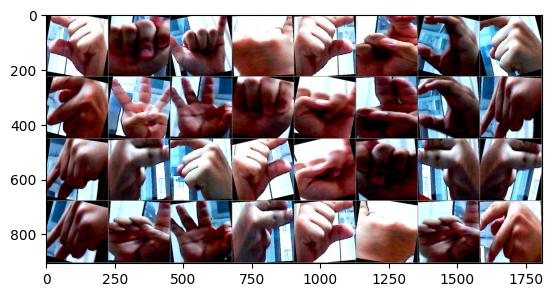

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = vutils.make_grid(images)

imshow(img_grid)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#CustomCNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {train_accuracy*100}%")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy*100}%")

    return model

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10, Loss: 1.2591656280984713, Accuracy: 73.992673992674%
Validation Accuracy: 100.0%
Epoch 2/10, Loss: 0.020453303098018, Accuracy: 99.5970695970696%
Validation Accuracy: 100.0%
Epoch 3/10, Loss: 0.02743569266343446, Accuracy: 99.30402930402931%
Validation Accuracy: 100.0%
Epoch 4/10, Loss: 0.03797312404758697, Accuracy: 99.1941391941392%
Validation Accuracy: 96.85314685314685%
Epoch 5/10, Loss: 0.030435686494879623, Accuracy: 99.45054945054946%
Validation Accuracy: 100.0%
Epoch 6/10, Loss: 0.030201764600395448, Accuracy: 98.97435897435898%
Validation Accuracy: 98.95104895104895%
Epoch 7/10, Loss: 0.02977562577014523, Accuracy: 99.08424908424908%
Validation Accuracy: 100.0%
Epoch 8/10, Loss: 0.002529779009597236, Accuracy: 99.8901098901099%
Validation Accuracy: 100.0%
Epoch 9/10, Loss: 0.013645385620399138, Accuracy: 99.63369963369964%
Validation Accuracy: 100.0%
Epoch 10/10, Loss: 0.000174368242691936, Accuracy: 100.0%
Validation Accuracy: 100.0%


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 26)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model_acc(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {train_accuracy*100}%")

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Accuracy: {val_accuracy*100}%")

    return val_accuracy  # validation accuracy

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.0001, 0.001]
}

grid = ParameterGrid(param_grid)

best_model_params = None
best_model = None
best_accuracy = 0.0

for params in grid:
    print(f"Training with params: {params}")

    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']

    model = CustomCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    val_accuracy = train_model_acc(model, train_loader, val_loader, criterion, optimizer)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_model_params = params

print(f"Best Validation Accuracy: {best_accuracy * 100}%")
print(f"Best Hyperparameters: {best_model_params}")

Training with params: {'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Epoch 1/10, Loss: 0.6151522209997787, Accuracy: 88.93772893772893%
Validation Accuracy: 100.0%
Epoch 2/10, Loss: 0.02813263860162954, Accuracy: 99.92673992673993%
Validation Accuracy: 100.0%
Epoch 3/10, Loss: 0.010412336570795539, Accuracy: 99.96336996336996%
Validation Accuracy: 97.55244755244755%
Epoch 4/10, Loss: 0.01107078492316569, Accuracy: 99.8901098901099%
Validation Accuracy: 100.0%
Epoch 5/10, Loss: 0.004528340790150037, Accuracy: 100.0%
Validation Accuracy: 99.82517482517483%
Epoch 6/10, Loss: 0.006460442501499296, Accuracy: 100.0%
Validation Accuracy: 99.47552447552448%
Epoch 7/10, Loss: 0.006050375306459014, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 8/10, Loss: 0.0026851265304072133, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 9/10, Loss: 0.020667210218583254, Accuracy: 99.81684981684981%
Validation Accuracy: 99.65034965034964%
Epoch 10/10, Loss: 0.0030334185034599764, 

In [ ]:
best_batch_size = best_model_params['batch_size']
best_learning_rate = best_model_params['learning_rate']
best_weight_decay = best_model_params['weight_decay']

model = CustomCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

epochs = 10
criterion = nn.CrossEntropyLoss()


final_trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/10, Loss: 0.5171808425207124, Accuracy: 90.03663003663004%
Validation Accuracy: 100.0%
Epoch 2/10, Loss: 0.018508710032112376, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 3/10, Loss: 0.007992067490704358, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 4/10, Loss: 0.004335057093263712, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 5/10, Loss: 0.004011374248494935, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 6/10, Loss: 0.011235088238568414, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 7/10, Loss: 0.0379377378551506, Accuracy: 99.48717948717949%
Validation Accuracy: 100.0%
Epoch 8/10, Loss: 0.0029652362119482268, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 9/10, Loss: 0.0025630016827436035, Accuracy: 99.96336996336996%
Validation Accuracy: 100.0%
Epoch 10/10, Loss: 0.008808415108306204, Accuracy: 99.85347985347985%
Validation Accuracy: 100.0%


In [ ]:
import torch
import torch.nn as nn

class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 26)

        # RNN
        self.rnn = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(512)

    def forward(self, x):

        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model_with_rnn = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.4943046656458877, Accuracy: 90.18315018315019%
Validation Accuracy: 100.0%
Epoch 2/10, Loss: 0.020700797222034877, Accuracy: 99.8901098901099%
Validation Accuracy: 100.0%
Epoch 3/10, Loss: 0.006121693030108026, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 4/10, Loss: 0.0030916466981410805, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 5/10, Loss: 0.0016211744832405604, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 6/10, Loss: 0.0012676410808845227, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 7/10, Loss: 0.0008064453766903256, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 8/10, Loss: 0.0006516257190649116, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 9/10, Loss: 0.0005564328741964473, Accuracy: 100.0%
Validation Accuracy: 100.0%
Epoch 10/10, Loss: 0.00046649291724924996, Accuracy: 100.0%
Validation Accuracy: 100.0%


In [ ]:
from sklearn.metrics import classification_report
import torch

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(classification_report(all_labels, all_preds))

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

evaluate_model(final_trained_model, test_loader, device)

evaluate_model(trained_model_with_rnn, test_loader, device)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        23
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        23
          14       1.00      1.00      1.00        23
          15       1.00      1.00      1.00        23
          16       1.00      1.00      1.00        23
          17       1.00    

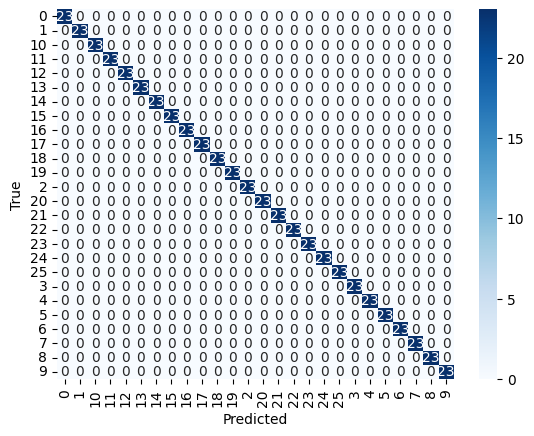

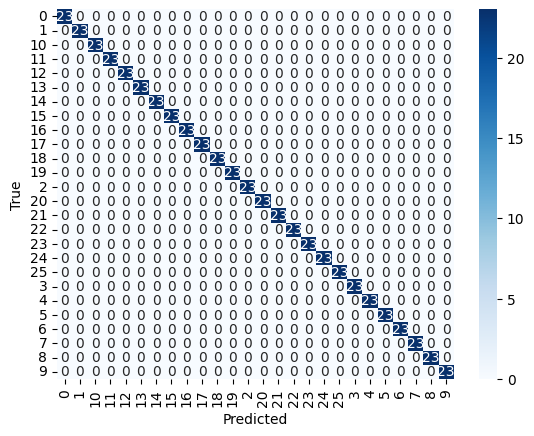

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(final_trained_model, test_loader)
plot_confusion_matrix(trained_model_with_rnn, test_loader)

In [ ]:
import wandb
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

wandb.init(
    project="sign-language",
    config={
        "learning_rate": best_learning_rate,
        "batch_size": best_batch_size,
        "weight_decay": best_weight_decay,
        "epochs": 10,
        "architecture": "CustomCNN",
    }
)

best_batch_size = best_model_params['batch_size']
best_learning_rate = best_model_params['learning_rate']
best_weight_decay = best_model_params['weight_decay']

model = CustomCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

epochs = 10

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct_preds = 0
        total_preds = 0
        all_labels = []
        all_preds = []

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = output.max(1)
            correct_preds += predicted.eq(target).sum().item()
            total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_loss = epoch_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()

                _, predicted = output.max(1)
                correct_preds += predicted.eq(target).sum().item()
                total_preds += target.size(0)

                all_labels.extend(target.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds

        val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        cm = confusion_matrix(all_labels, all_preds)

        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title(f"Confusion Matrix - Epoch {epoch + 1}")

        plt.tight_layout()
        plt.savefig("confusion_matrix_epoch_{}.png".format(epoch + 1))
        plt.close()

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_precision": train_precision,
            "train_recall": train_recall,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "val_f1": val_f1,
            "confusion_matrix": wandb.Image("confusion_matrix_epoch_{}.png".format(epoch + 1))  # Log confusion matrix as an image
        })

    return model

trained_model_wb = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

wandb.finish()

wandb: Currently logged in as: alibek-musabek (alibek-musabek-aitu). Use `wandb login --relogin` to force relogin


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁█████████
train_f1,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
train_precision,▁█████████
train_recall,▁█████████
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▂▂▂▁▁▁
val_precision,▁▁▁▁▁▁▁▁▁▁
val_recall,▁▁▁▁▁▁▁▁▁▁


In [ ]:
wandb.init(
    project="sign-language",
    config={
        "learning_rate": best_learning_rate,
        "batch_size": best_batch_size,
        "weight_decay": best_weight_decay,
        "epochs": 10,
        "architecture": "CustomCNN",
    }
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_on_test_set(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    correct_preds = 0
    total_preds = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            correct_preds += predicted.eq(target).sum().item()
            total_preds += target.size(0)

            all_labels.extend(target.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct_preds / total_preds

    test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix - Test Set")

    plt.tight_layout()
    plt.savefig("confusion_matrix_test.png")
    plt.close()

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "test_f1": test_f1,
        "confusion_matrix_test": wandb.Image("confusion_matrix_test.png")
    })

evaluate_on_test_set(trained_model_wb, test_loader)

wandb.finish()

test_accuracy,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
test_accuracy,1
test_f1,1
test_loss,0.00052
test_precision,1
test_recall,1
